In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load Dataset

In [2]:
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset

2025-04-12 16:32:38.958 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
torch_device = "cpu"
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["validation"],
)
lsb_dataset = LbsDataset(lsb_connector, device=appconfig.TORCH_DEVICE, augmentation=False)
lsb_dataloader = lsb_dataset.get_dataloader()

Loading tasks:   1%|          | 1/100 [00:01<02:19,  1.41s/it]
2025-04-12 16:32:43.154 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 16
2025-04-12 16:32:43.154 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 7


In [4]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assume you already have a DataLoader
# Each sample is (image_tensor, target), and target has 'boxes' and 'labels'
def visualize_proposals(image_tensor, targets, outputs, score_thresh):
    img = to_pil_image(image_tensor.cpu())
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Ground truth boxes (in green)
    for box in targets["boxes"]:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    # Predicted boxes (in red)
    for box, score in zip(outputs["boxes"], outputs["scores"]):
        if score >= score_thresh:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{score:.2f}', color='white', fontsize=8,
                    bbox=dict(facecolor='red', edgecolor='none', pad=1))
    plt.axis('off')
    plt.show()

# Test loop for one image
def test_one_batch(dataloader, score_thresh=0.5):
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for i in range(len(images)):
                visualize_proposals(images[i].cpu(), targets[i], outputs[i], score_thresh)
            break  # Remove this to go over full dataset


/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


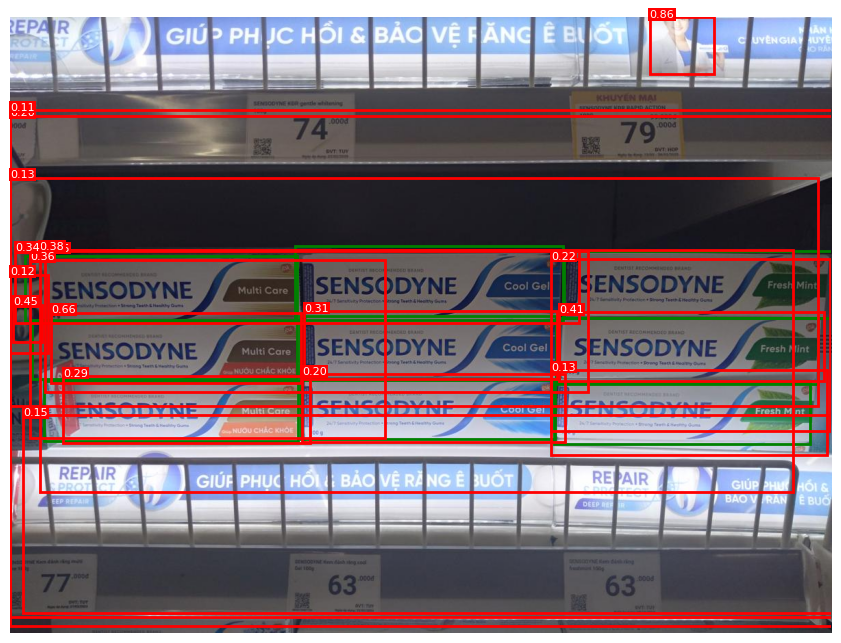

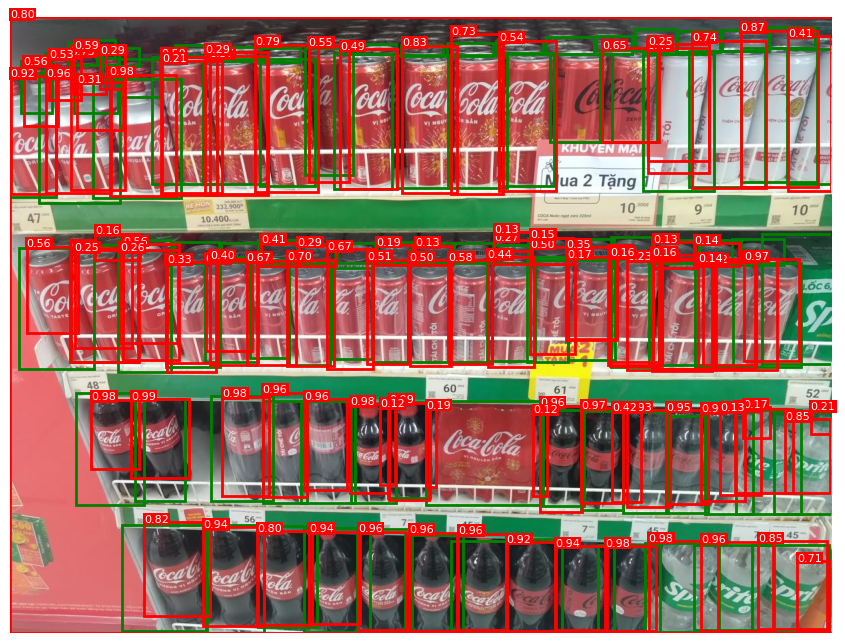

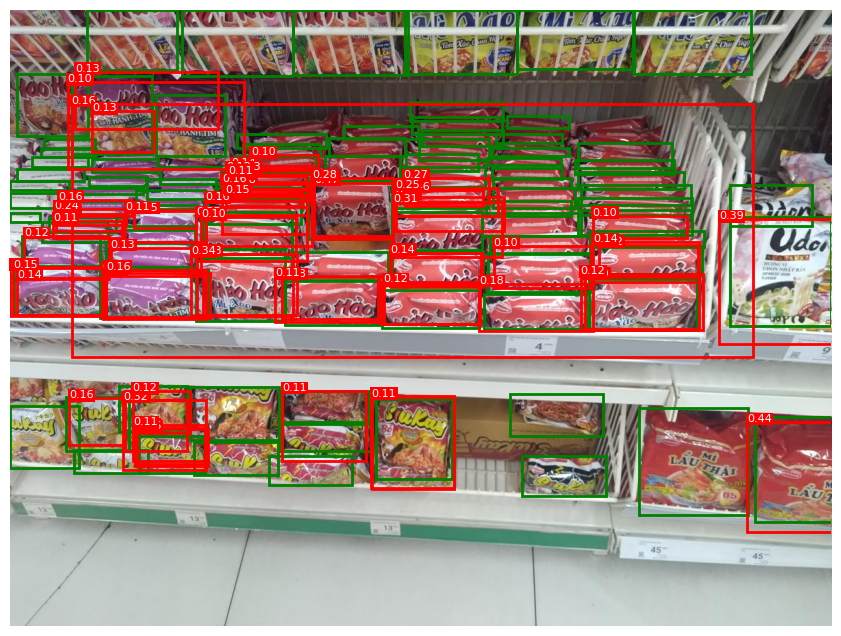

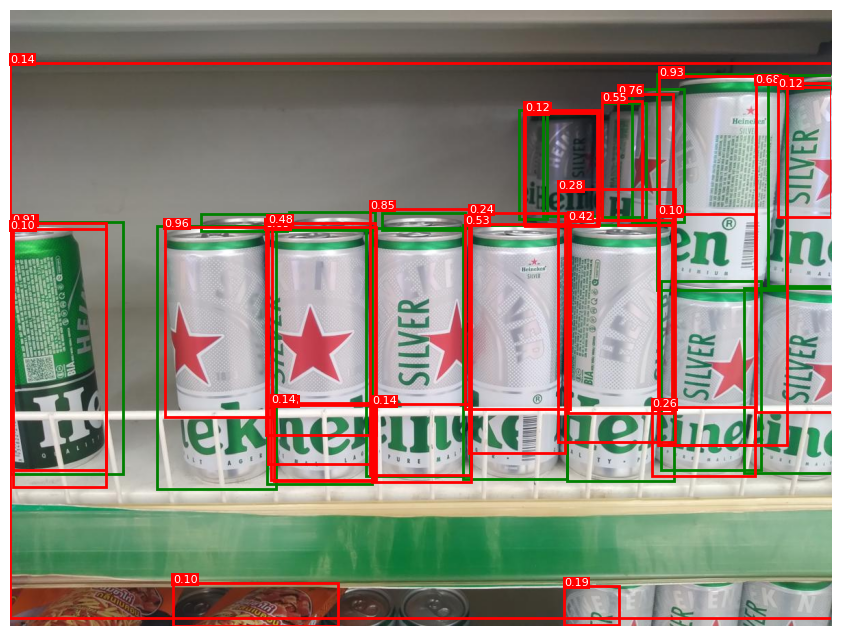

In [5]:
test_one_batch(lsb_dataloader, score_thresh=0.1)